In [321]:
# Let's import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score
# pd.set_option('display.max_columns', None)

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

## Data verification
- verifying if all the columns has data

### Observation
- Many columns has null values

In [322]:
housingData = pd.read_csv("train.csv")
print(housingData.info())
# housingData = housingData.drop(['GrLivArea', 'OverallQual','OverallCond', 'GarageCars','MSZoning'], axis=1)
housingData.shape
# 'GrLivArea','OverallQual','OverallCond','GarageCars','MSZoning_RL'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

(1460, 81)

### Analysing NA values
- According data dictonary NA value represet item not available , not the value no available
- We need to separate numeric columns and add zero in place of NA values
- We need to replace NA with notavail in categorical columns
### Below section remove NA value to zero in numric column and notavail in categorical column

In [323]:
# Extracting numberic columns and replacing NA with zero
housngDtNumColsDf = housingData.select_dtypes(include=['float64', 'int64'])
housingDtNumColLst=list(housngDtNumColsDf.columns)
housingData[housingDtNumColLst]=housingData[housingDtNumColLst].fillna(0)
print('total numeric colmns ',len(housingDtNumColLst))
print('Numeric columns \n',housingData[housingDtNumColLst].isna().sum(),'\n\n\n')


# Extracting catagorical columns and replacing NA with notavail
housngDtCatColsDf=housingData.select_dtypes(include=['object'])
housingDtCatColLst=list(housngDtCatColsDf.columns)
housingData[housingDtCatColLst]=housingData[housingDtCatColLst].fillna('notavail')
print('total categorical colmns ',len(housingDtCatColLst))
print('categorical columns \n',housingData[housingDtCatColLst].isna().sum())

# Removing dataframe for efiicient memory utilization
import gc
del housngDtNumColsDf
del housngDtCatColsDf
gc.collect()


total numeric colmns  38
Numeric columns 
 Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64 



total categorical colmns  43
categorical columns 
 MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood   

45983

### Analysing catagorical columns, remove columns having less than 10% variance
- We try to identify data distribution in each categorical column. There are many columns in which we have 90% representation of a single category. These type of columns doesn't contribute to the pridiction of target variable as most data belong to one value
- we will remove all those columns which has representation of a single value more than 90%, i.e variance less than 10 percent

In [324]:
colLen=len(housingData.columns)
housingDataColLst=list(housingData.columns)
columns_over_90_percent =[]
for i in range(colLen):
    if any(housingData[housingDataColLst[i]].astype('category').value_counts(normalize=True) > 0.90):
        print('\n',housingData[housingDataColLst[i]].astype('category').value_counts(normalize=True)*100,'\n\n')
        columns_over_90_percent.append(housingDataColLst[i])
print(columns_over_90_percent) 


 Pave    99.589041
Grvl     0.410959
Name: Street, dtype: float64 



 notavail    93.767123
Grvl         3.424658
Pave         2.808219
Name: Alley, dtype: float64 



 AllPub    99.931507
NoSeWa     0.068493
Name: Utilities, dtype: float64 



 Gtl    94.657534
Mod     4.452055
Sev     0.890411
Name: LandSlope, dtype: float64 



 Norm      98.972603
Feedr      0.410959
Artery     0.136986
PosN       0.136986
RRNn       0.136986
PosA       0.068493
RRAe       0.068493
RRAn       0.068493
Name: Condition2, dtype: float64 



 CompShg    98.219178
Tar&Grv     0.753425
WdShngl     0.410959
WdShake     0.342466
ClyTile     0.068493
Membran     0.068493
Metal       0.068493
Roll        0.068493
Name: RoofMatl, dtype: float64 



 GasA     97.808219
GasW      1.232877
Grav      0.479452
Wall      0.273973
OthW      0.136986
Floor     0.068493
Name: Heating, dtype: float64 



 Y    93.493151
N     6.506849
Name: CentralAir, dtype: float64 



 SBrkr       91.369863
FuseA        6.438356
F

21


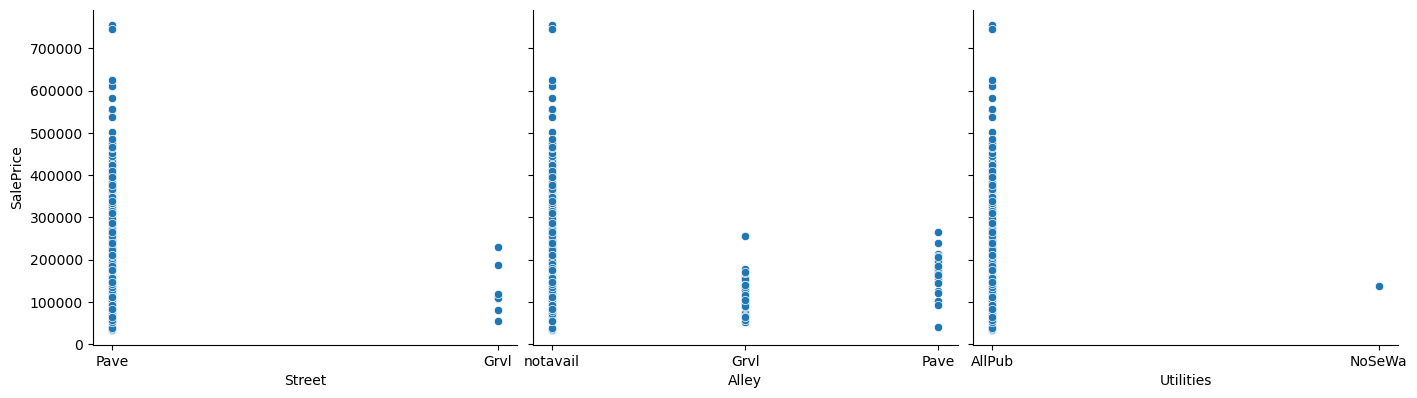

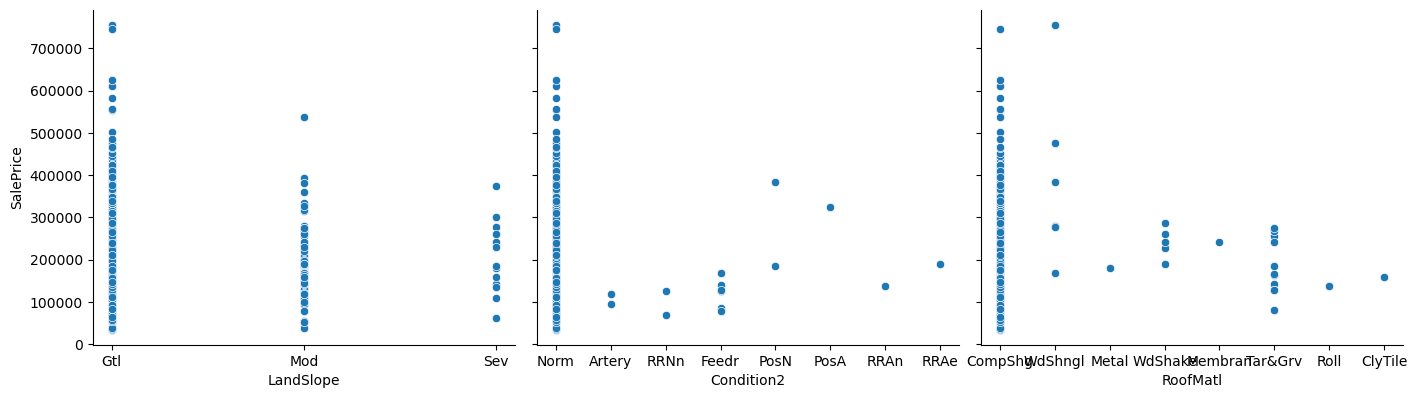

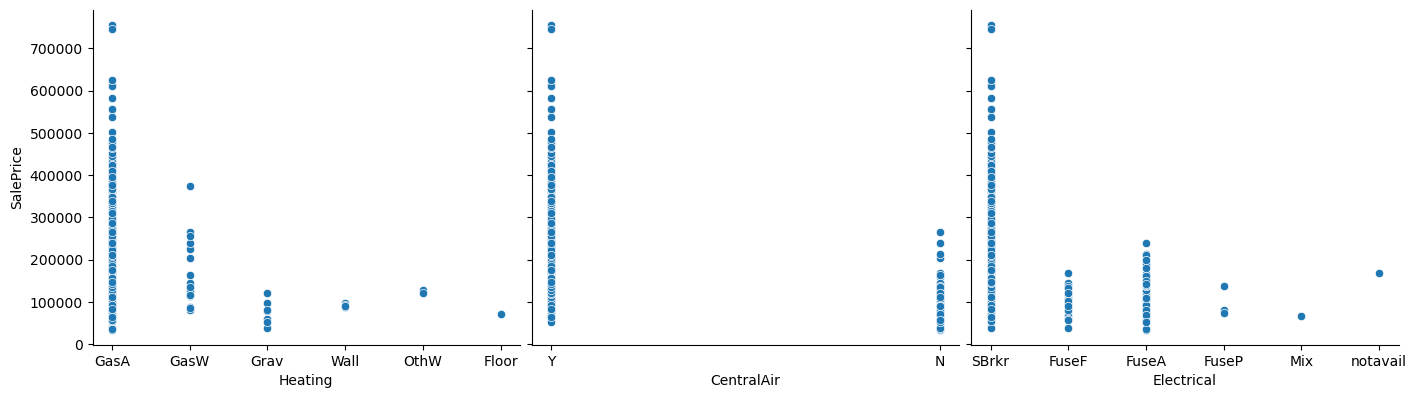

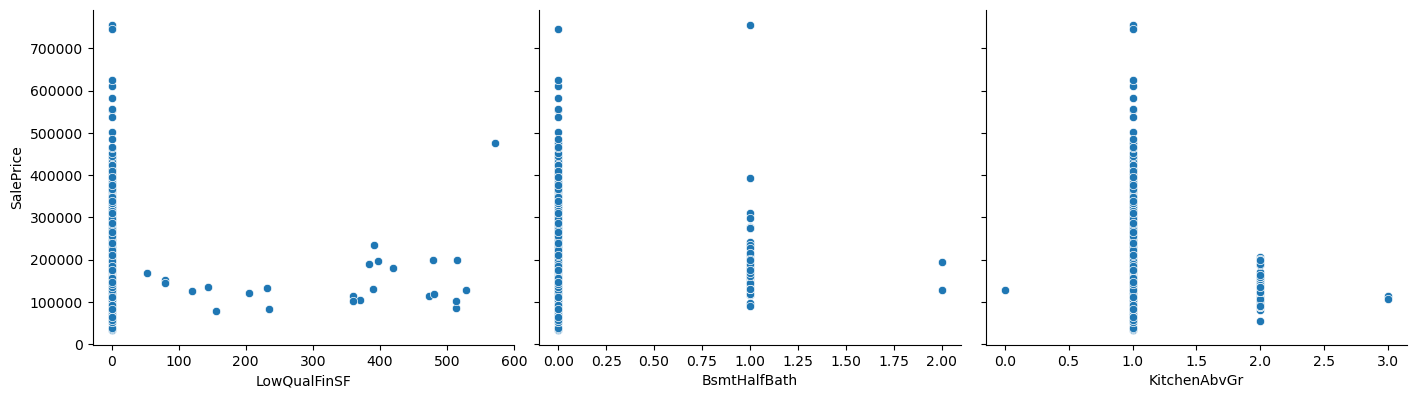

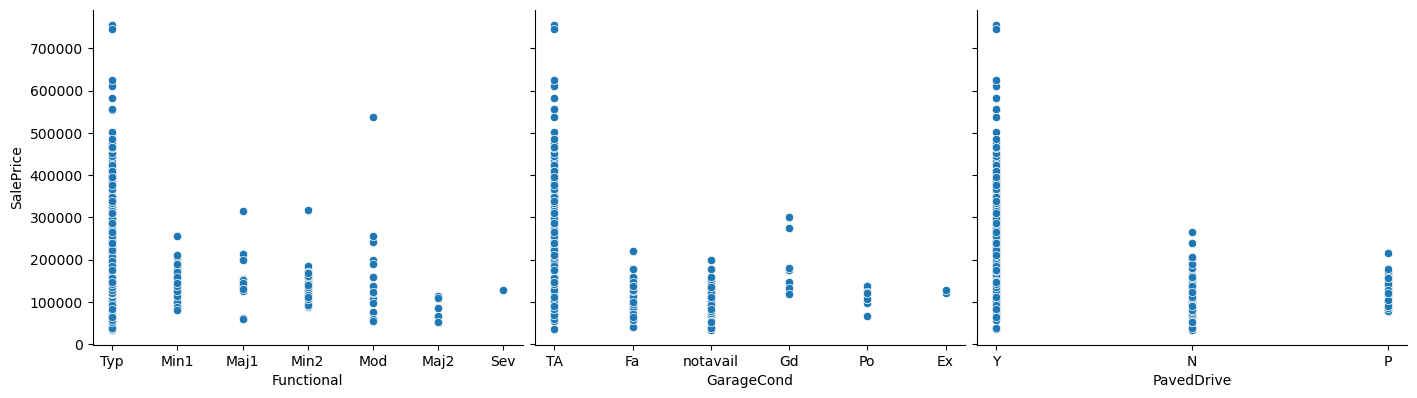

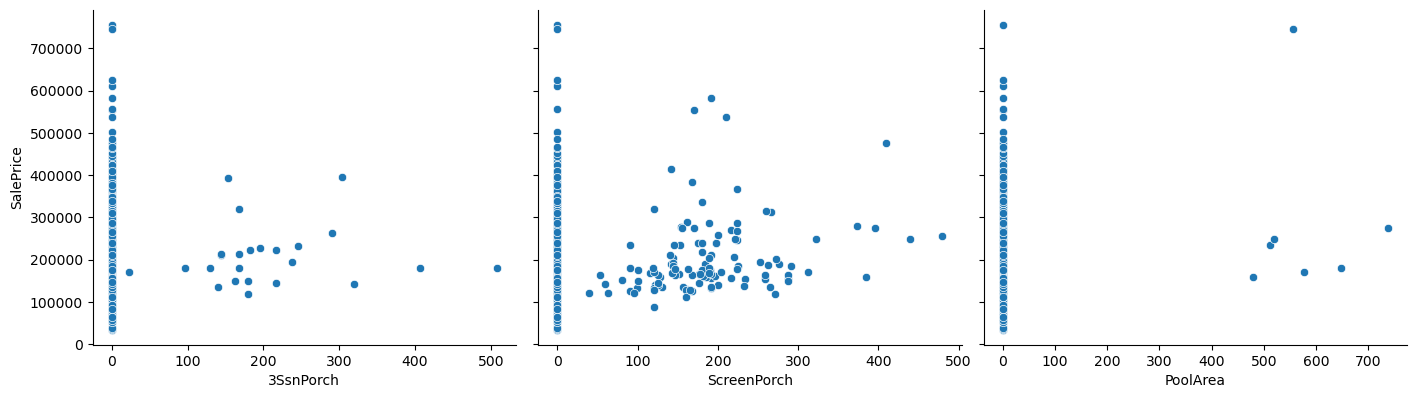

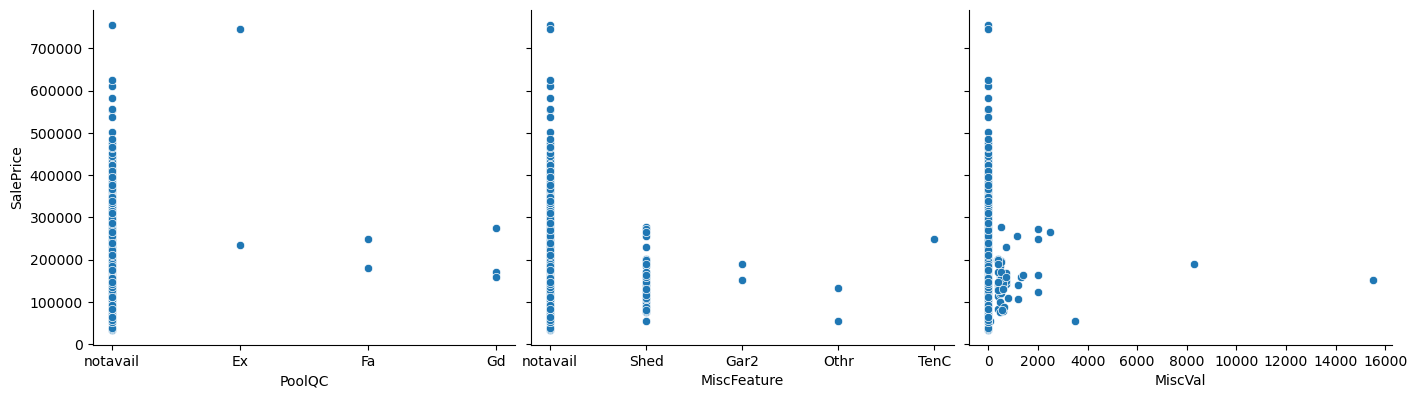

In [325]:
xcols= []
colLstLen=len(columns_over_90_percent)
print(colLstLen)
for i in range(0,colLstLen,3):
    if(i+3>colLstLen-1):
        if(i<=colLstLen-1):
            xcols.append(columns_over_90_percent[i])
        if(i+1<=colLstLen-1):
            xcols.append(columns_over_90_percent[i+1])
        if(i+2<=colLstLen-1):
            xcols.append(columns_over_90_percent[i+2])
        sns.pairplot(data=housingData, y_vars='SalePrice', x_vars=xcols,height=4, aspect=1.2)
    else:
        xcols.append(columns_over_90_percent[i])
        xcols.append(columns_over_90_percent[i+1])
        xcols.append(columns_over_90_percent[i+2])
        sns.pairplot(data=housingData, y_vars='SalePrice', x_vars=xcols,height=4, aspect=1.2)
    xcols.clear()

plt.show()


### Above pairplot shows columns having less variance against target variable. 
--- as these columns have less variance they hold less predictive power, so we can remove these columns

## Removing columns having more than 90% of value concentration to a single value (less variance)

In [326]:
housingData.drop(columns_over_90_percent, axis=1,inplace=True)
housingData.shape

(1460, 60)

##### Removing ID column as it has no predictive power

In [327]:
housingData.drop(columns=['Id'],inplace=True)
housingData.shape

(1460, 59)

<Axes: xlabel='SalePrice', ylabel='Density'>

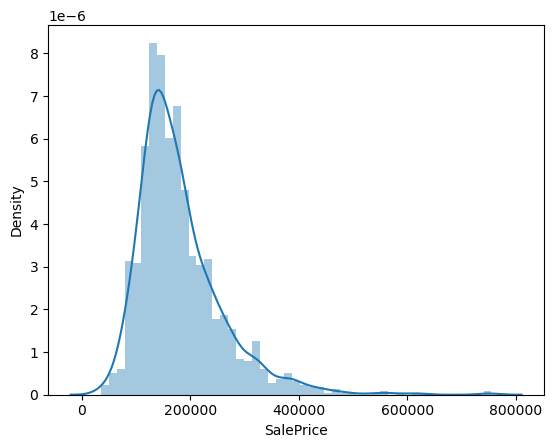

In [328]:
sns.distplot(housingData['SalePrice'])

### Distplot of the target variable SalesPrice shows that values are trailing towards right end of trail
--- Applying log to centralize data

<Axes: xlabel='SalePrice', ylabel='Density'>

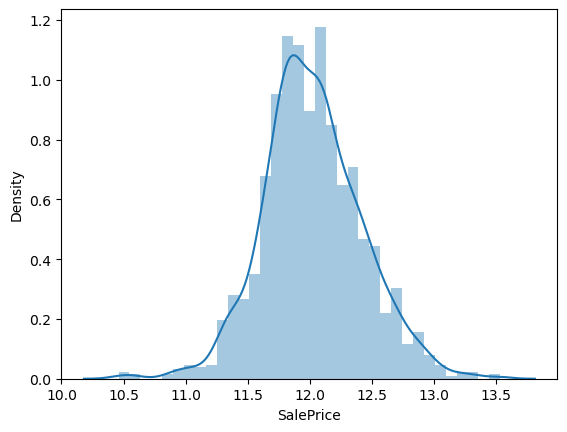

In [329]:
housingData['SalePrice']=np.log1p(housingData['SalePrice'])
sns.distplot(housingData['SalePrice'])

### Analysing if independent variables has linear relationship with target variable (SalesPrice)
- Heat map shows that many independent variables has linear relationship with Target Variable(salesprice)
- Heat map is created typically between numeric variables
- There are many independent Variables which linearly dependent creating <b> Multicolinearity</b>, but we are not removing these columns as multicolinearity is handled itself in Ridge and Lasso

(1460, 59)


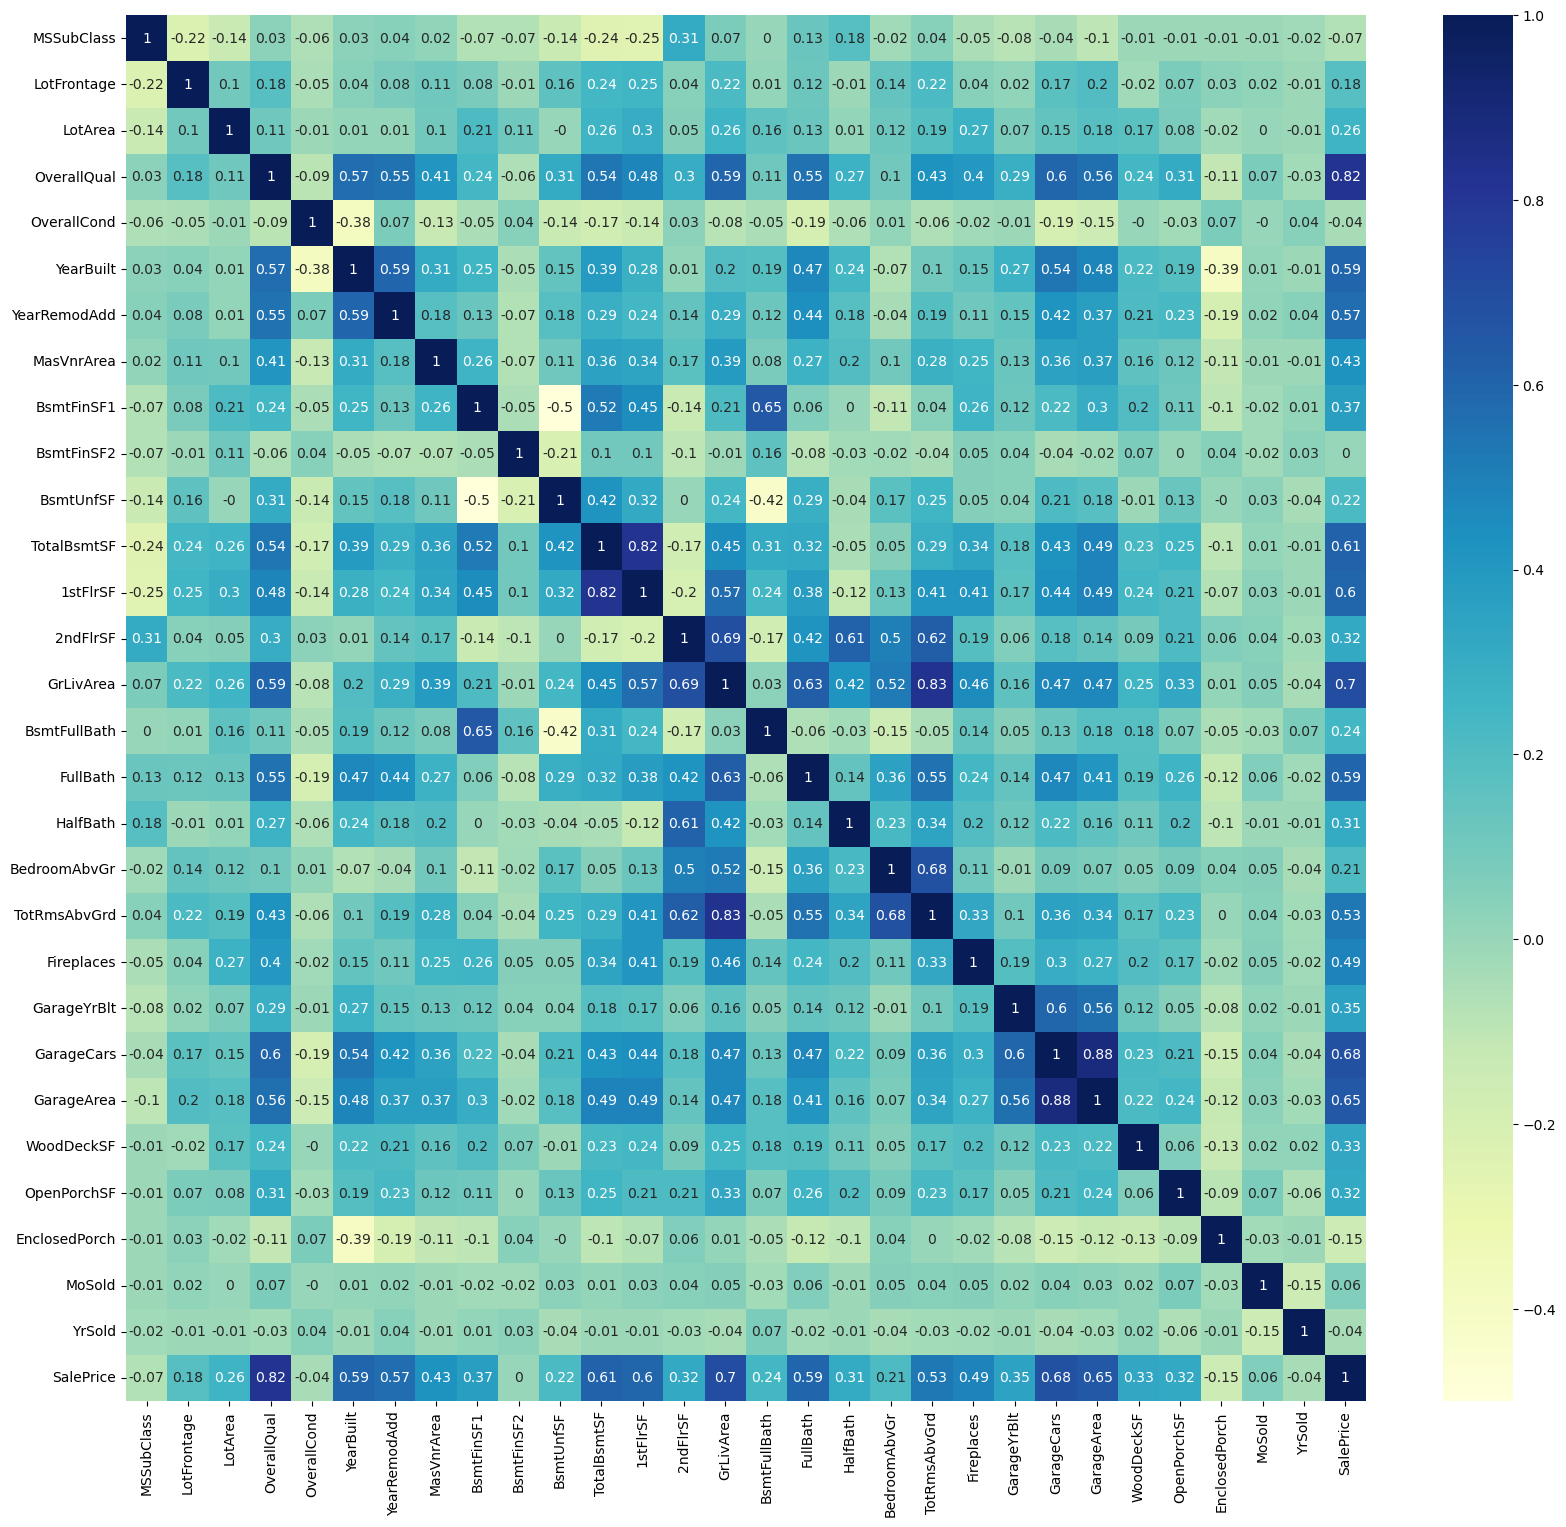

In [330]:
print(housingData.shape)
cor=housingData.corr()
plt.figure(figsize=(20,18))

# heatmap
sns.heatmap(round(cor,2), cmap="YlGnBu", annot=True)
plt.show()

In [331]:
housingData.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,57.623288,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,0.613014,1868.739726,1.767123,472.980137,94.244521,46.660274,21.954110,6.321918,2007.815753,12.024057
std,42.300571,34.664304,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,0.644666,453.697295,0.747315,213.804841,125.338794,66.256028,61.119149,2.703626,1.328095,0.399449
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.460271
25%,20.000000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,1958.000000,1.000000,334.500000,0.000000,0.000000,0.000000,5.000000,2007.000000,11.775105
50%,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,1.000000,1977.000000,2.000000,480.000000,0.000000,25.000000,0.000000,6.000000,2008.000000,12.001512
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,8.000000,2009.000000,12.273736
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,12.000000,2010.000000,13.534474


### Creating dummies for categorical columns

In [332]:

temCatColLst=list(housingData.select_dtypes(include=['object']).columns)
print(temCatColLst,'\n\n')

housingDataCatDummiesTemp=pd.get_dummies(housingData[temCatColLst],drop_first=True)
print('Housing data before concatinating dummies',housingData.shape)

housingData=pd.concat([housingData,housingDataCatDummiesTemp],axis=1)
print('Housing data after concatinating dummies',housingData.shape)

housingData=housingData.drop(columns=temCatColLst)
print('Housing data after dropping orginal colmns',housingData.shape)

housingData

['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'Fence', 'SaleType', 'SaleCondition'] 


Housing data before concatinating dummies (1460, 59)
Housing data after concatinating dummies (1460, 233)
Housing data after dropping orginal colmns (1460, 204)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,0,1,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,0,1,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,0,1,0,0,0,1,0


### Spliting Data into test and train

In [333]:
train_housingData, test_housingData=train_test_split(housingData,train_size=.7, 
                                                               test_size = 0.3,random_state=100)
print('train data ',train_housingData.shape)
print('test data ',test_housingData.shape)

train data  (1021, 204)
test data  (438, 204)


## Scaling Train Data

In [334]:
scalingNumColLst =list(train_housingData.select_dtypes(include=['float64','int64']).columns)
scalingNumColLst
scaler =MinMaxScaler()
train_housingData[scalingNumColLst]=scaler.fit_transform(train_housingData[scalingNumColLst])
train_housingData.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,0.058824,0.214058,0.019306,0.444444,0.625,0.384058,0.000000,0.00,0.082920,0.0,...,0,0,0,0,1,0,0,0,1,0
318,0.235294,0.287540,0.039403,0.666667,0.500,0.876812,0.716667,0.16,0.174876,0.0,...,0,0,0,0,1,0,0,0,1,0
239,0.176471,0.166134,0.033981,0.555556,0.375,0.528986,0.000000,0.00,0.016655,0.0,...,0,0,0,0,1,0,0,0,1,0
986,0.176471,0.188498,0.017931,0.555556,0.875,0.275362,0.883333,0.00,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
1416,1.000000,0.191693,0.046139,0.333333,0.625,0.094203,0.000000,0.00,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0


## Scaling Test Data

In [335]:
test_housingData[scalingNumColLst]=scaler.transform(test_housingData[scalingNumColLst])
test_housingData.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1436,0.000000,0.191693,0.035192,0.333333,0.625,0.717391,0.350000,0.00000,0.109142,0.0,...,0,0,0,0,1,0,0,0,1,0
57,0.235294,0.284345,0.047566,0.666667,0.500,0.956522,0.900000,0.00000,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
780,0.000000,0.201278,0.029930,0.666667,0.500,0.891304,0.766667,0.02375,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
382,0.235294,0.252396,0.036338,0.666667,0.500,0.971014,0.933333,0.00000,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
1170,0.352941,0.242812,0.039309,0.555556,0.625,0.760870,0.450000,0.00000,0.092488,0.0,...,0,0,0,0,1,0,0,0,1,0


## Extracting x and y test train data

In [336]:
# separating train data into dependent and independent variable
y_train=train_housingData.pop('SalePrice')
x_train=train_housingData
# separating test data into dependent and independent variable
y_test=test_housingData.pop('SalePrice')
x_test=test_housingData

## Linear Regression model

In [337]:
from sklearn.feature_selection import RFE

linearRegression=LinearRegression()
linearRegression.fit(x_train,y_train)
rfe=RFE(linearRegression, n_features_to_select=77)
rfe=rfe.fit(x_train,y_train)

feature_ranking=list(zip(x_train.columns,rfe.support_,rfe.ranking_))

# feature_ranking

rfeColLst=list(x_train.columns[rfe.support_])

print('RFE selected column: \n',x_train.columns[rfe.support_])
print('\n')
print('RFE not Selected column: \n',x_train.columns[~rfe.support_])


RFE selected column: 
 Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'WoodDeckSF',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'LotShape_IR3', 'LandContour_Low', 'LandContour_Lvl',
       'Neighborhood_BrDale', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_MeadowV', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_SWISU', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition1_Norm',
       'BldgType_Duplex', 'BldgType_Twnhs', 'Exterior1st_AsphShn',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'Exterior2nd_AsphShn', 'Exterior2nd_CBlock', 'Exterior2nd_Other',
       'Exterior2nd_Stucco', 'Ext

In [338]:
linearRegressionModel = LinearRegression()

# Fitting a line 
linearRegressionModel.fit(x_train[rfeColLst], y_train)

print('linearRegressionModel intercept Bo \n',round(linearRegressionModel.intercept_,3))
print('\nlinearRegressionModel Beta coefficents \n',linearRegressionModel.coef_)


linearRegressionModel intercept Bo 
 0.039

linearRegressionModel Beta coefficents 
 [-3.53180575e-02  1.11721413e-01  1.60903925e-01  1.06805969e-01
  1.09051473e-01  2.19543631e-02 -1.19468741e+11 -3.12007308e+10
 -4.94470198e+10  1.29332744e+11  1.47897601e-01  5.57327271e-02
  1.98339462e-01  6.02703094e-02  2.20336914e-02  3.16123962e-02
  3.16658020e-02  8.15162659e-02  2.42757797e-02  1.16490364e-01
  1.32943153e-01  1.28929138e-01  1.13821030e-01 -3.99641991e-02
  2.97431946e-02  1.96762085e-02 -1.85294151e-02  3.37448120e-02
  6.28223419e-02 -2.77624130e-02 -3.04813385e-02  3.58123779e-02
  3.90357971e-02  1.77993774e-02  4.11610603e-02  5.43746948e-02
  2.64425278e-02  1.94511414e-02 -1.68838501e-02 -2.50473022e-02
  6.70381729e+08 -5.59921265e-02  3.58867645e-02 -1.09885849e+09
 -6.70381729e+08  1.09885849e+09  4.82030080e+08 -2.30531693e-02
 -8.66718292e-02 -6.94732666e-02 -7.27800329e+06 -6.46743774e-02
  5.45907021e-02 -2.95352936e-02 -2.81105042e-02 -3.24077606e-02
 -4.6

In [339]:
y_pred_train = linearRegressionModel.predict(x_train[rfeColLst])
y_pred_test = linearRegressionModel.predict(x_test[rfeColLst])

r2_train_lr = r2_score(y_train, y_pred_train)
r2_test_lr = r2_score(y_test, y_pred_test)

rssTrain_lr=np.sum(np.square(y_train-y_pred_train))
rssTest_lr=np.sum(np.square(y_test-y_pred_test))

mseTrain_lr = mean_squared_error(y_train, y_pred_train)
rmseTrain_lr=mseTrain_lr**.5


mseTest_lr = mean_squared_error(y_test, y_pred_test)
rmseTest_lr=mseTest_lr**.5

linearRegressionDict = {
    'Linear Regression':{'R2_score Train': r2_train_lr, 'R2_score Test': r2_test_lr, 'RSS Train': rssTrain_lr,
     'RSS Test': rssTest_lr, 'MSE Train': mseTrain_lr, 'MSE Test': mseTest_lr,'RMSE Train': rmseTrain_lr,
                        'RMSE Test': rmseTest_lr}
}

modelAnalysisDf = pd.DataFrame.from_dict(linearRegressionDict)
modelAnalysisDf

vifDf=pd.DataFrame()
vifColLst=x_train[rfeColLst].columns
vifDf['features']=vifColLst
vifDf['vif']=[variance_inflation_factor(x_train[rfeColLst].values,i) for i in range(x_train[rfeColLst].shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
print('VIF \n',vifDf.sort_values(by='vif',ascending=False))
modelAnalysisDf


VIF 
                  features   vif
76  SaleCondition_Partial   inf
40    Exterior1st_AsphShn   inf
44    Exterior2nd_AsphShn   inf
45     Exterior2nd_CBlock   inf
56      BsmtQual_notavail   inf
..                    ...   ...
62         FireplaceQu_Po  1.10
69           SaleType_Con  1.09
61           HeatingQC_Po  1.03
46      Exterior2nd_Other   NaN
50           ExterCond_Po   NaN

[77 rows x 2 columns]


,Linear Regression
MSE Test,1.127104e+18
MSE Train,1.480541e-03
R2_score Test,-6.473859e+19
R2_score Train,9.109850e-01
RMSE Test,1.061652e+09
RMSE Train,3.847780e-02
RSS Test,4.936716e+20
RSS Train,1.511633e+00


## Infinite VIF shows that multicollinearity is not handled by Linear Regression

## Interpretation of Linear Regression model

The model shows excellent performance on the training set but fails dramatically on the test set. This discrepancy typically indicates overfitting, where the model has learned the training data too closely, including its noise and anomalies, making it perform poorly on new, unseen data. 
R2 score for train is almost one 0.91. <b><u>This is a case of Overfitting</u></b>, resulting in a model that is not generalizable outside of its training dataset.

The negative R² value for the test set implies that the model's predictions are vastly worse than a simple average of the target values. 

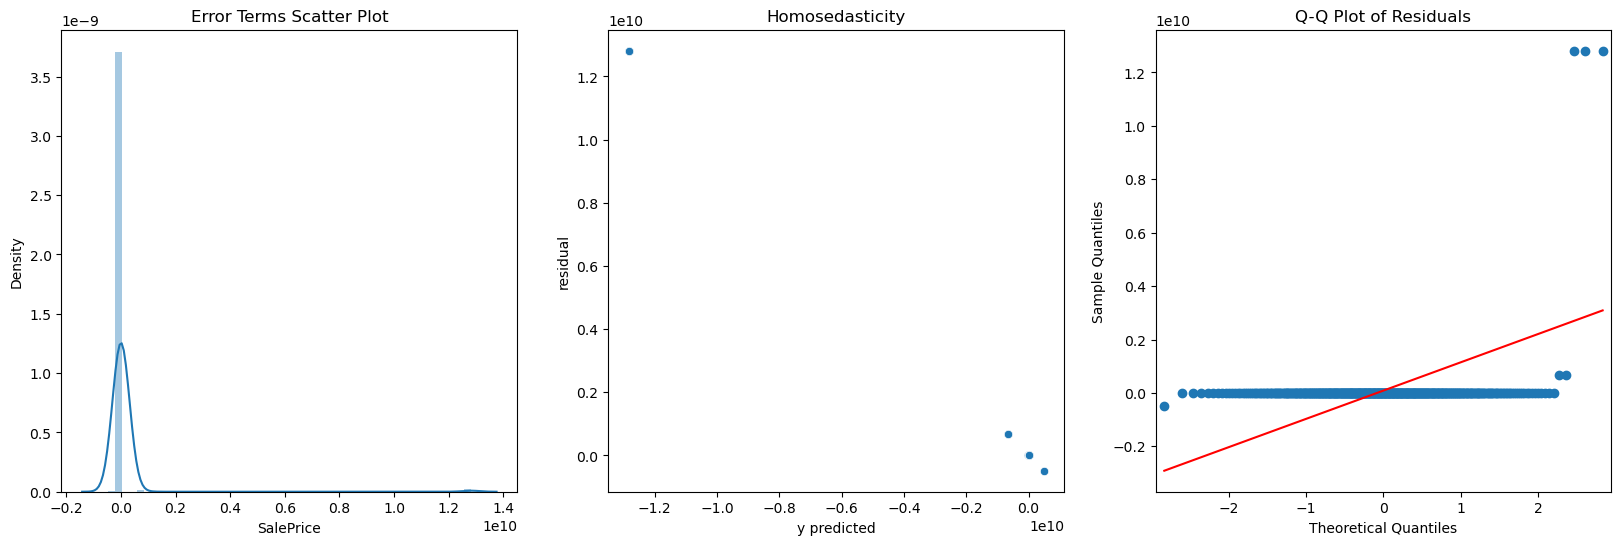

In [340]:
residual=y_test-y_pred_test

# Plotting y_test and y_pred to understand the spread.
fig, axis = plt.subplots(1, 3, figsize=(20, 6))

sns.distplot(residual,ax=axis[0])
axis[0].set_title("Error Terms Scatter Plot")

# Verifing Homescedasticity, that spread of residue or error terms should be constant accross all y train predicted
sns.scatterplot(x=y_pred_test,y=residual , ax=axis[1])
axis[1].set_xlabel('y predicted') 
axis[1].set_ylabel('residual') 
axis[1].set_title("Homosedasticity")
import scipy.stats as stats

# Create a Q-Q plot
sm.qqplot(residual, line='s', ax=axis[2])
axis[2].set_title("Q-Q Plot of Residuals")

plt.show()

### Observations
- Residual plot is skwed toward rightside and distribution is not normal.
  Plot also shows model will not be able to explain many values
- QQ plot also shows values are not normally distributed

# Linear Regression is not a good fit but we can make it a good fit by keep on reducing the features selected. This will also reduce complexity and variance of model,  but we will try to do it by using hyperparameter in Lasso and Ridge

## Lasso

In [341]:
params = {'alpha': [0.0001,0.0002, 0.001, 0.01, 0.05, 0.1,1,2,5,10.0,20.0,100]}

lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 
lassoModelBestParam=model_cv.best_params_
print('Best performing alpha is :',lassoModelBestParam['alpha'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best performing alpha is : 0.0001


### Plotting scatter plot between y test actual and y test pred with different alpha

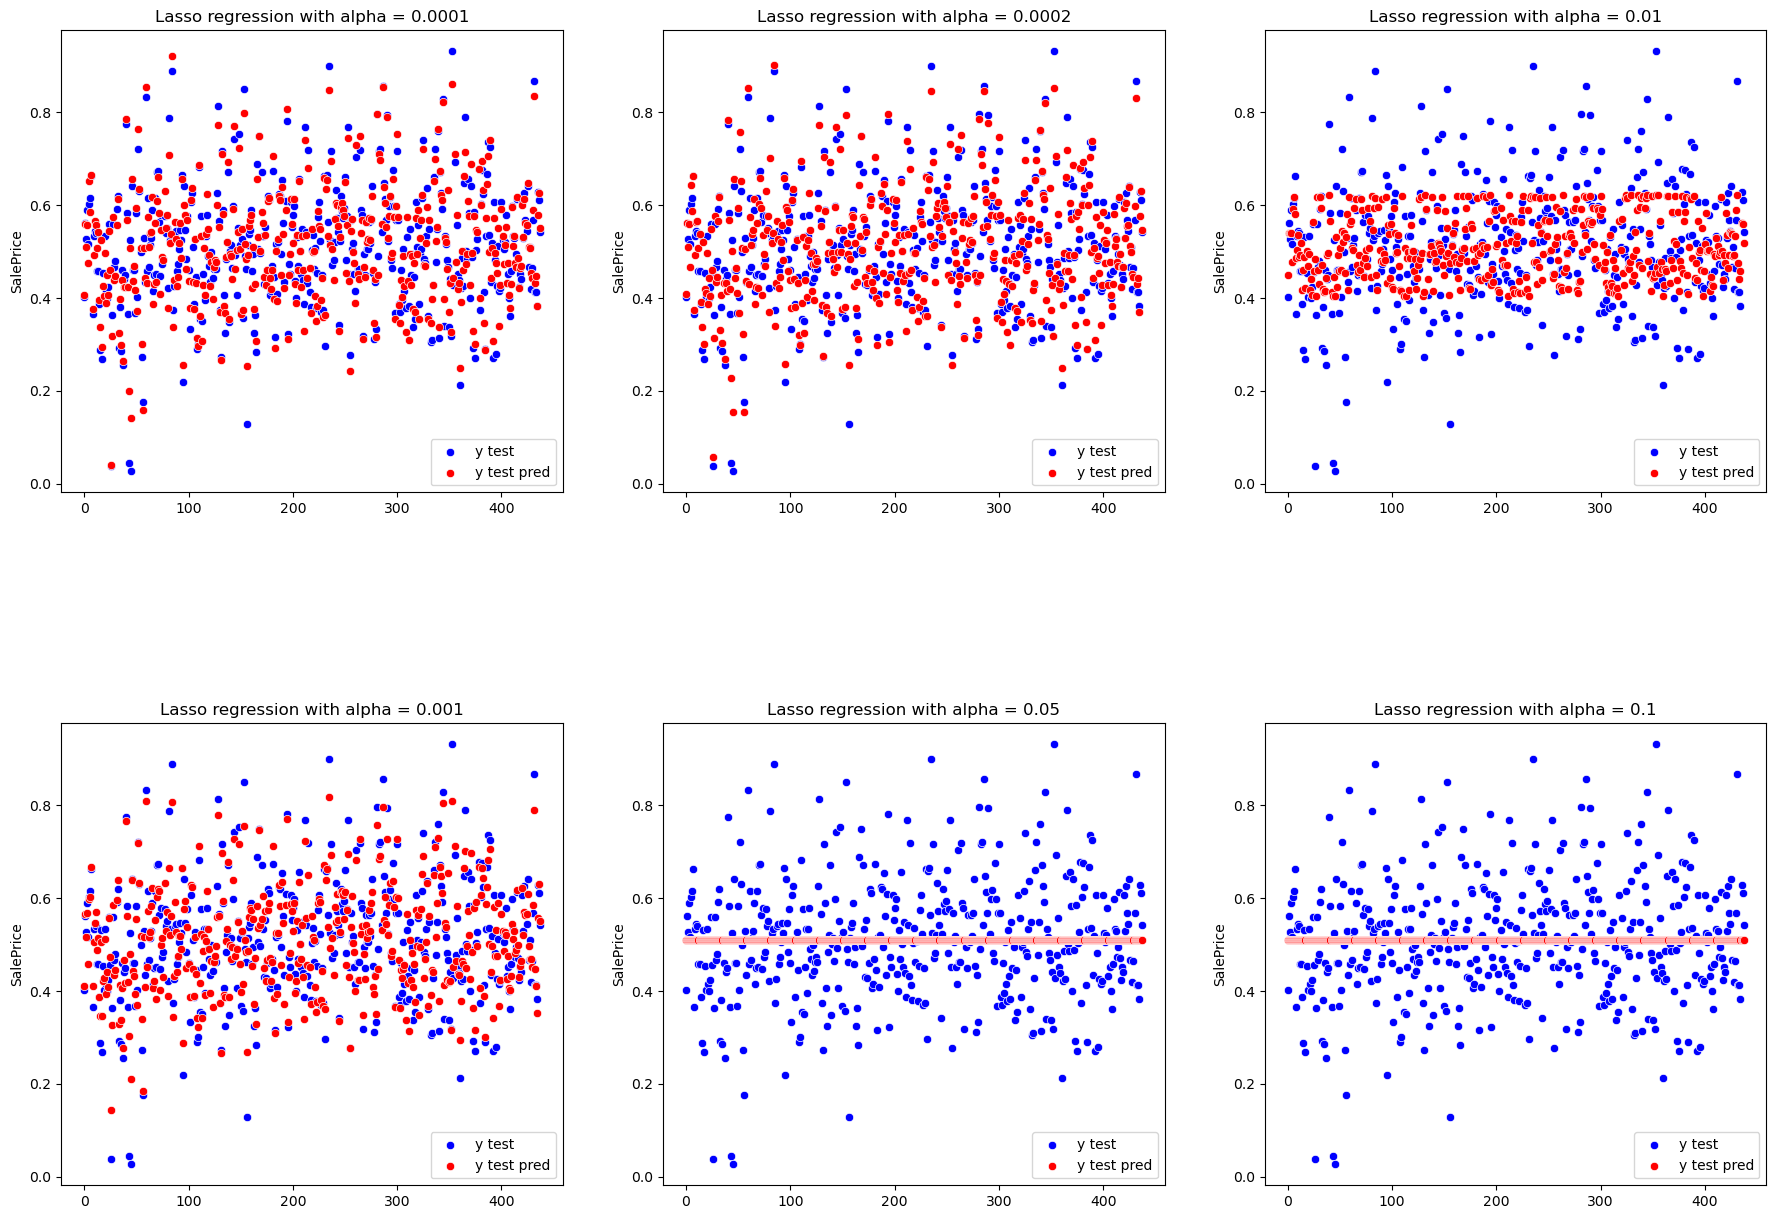

In [342]:
alphaParams=[0.0001,0.0002, 0.01, 0.001, 0.05, 0.1]
fig, axis = plt.subplots(2, 3, figsize=(22, 15))
row=0
col=0
for value in alphaParams:
    if col >=3:
        row=row+1
        col=0
        if row == 3:
            print('breaking')
            break
        
    lasso = Lasso(alpha=value)
    lasso.fit(x_test, y_test)
    sns.scatterplot(x=range(len(y_test)),y=y_test, ax=axis[row,col],color="blue")
    sns.scatterplot(x=range(len(y_test)),y=lasso.predict(x_test), ax=axis[row,col],color="red")
    axis[row,col].set_title(f"Lasso regression with alpha = {value}")
    axis[row,col].legend(['y test','y test pred'])
    col=col+1  
    
plt.subplots_adjust(hspace=0.5)
plt.show()    

### Observation 
- it can be observed that there is not much differernce between the plot of atual target variable and predicted target variable
from alpha .0001 to .001
- aplha from .01 started showing that model has become too simple to cover all the variation and bias has also increased significantly
- Although based on the other parameters such as mean score time, mean fit time etc. alpha .0001 is best


In [343]:
gridSearchStats=pd.DataFrame(model_cv.cv_results_)
gridSearchStats

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.027916,3.613994e-03,0.004189,1.163088e-03,0.0001,{'alpha': 0.0001},-0.028629,-0.031058,-0.033382,-0.026534,...,-0.030045,0.002316,1,-0.026146,-0.022789,-0.023630,-0.026462,-0.025965,-0.024998,0.001493
1,0.013963,1.092798e-03,0.003989,6.309018e-04,0.0002,{'alpha': 0.0002},-0.028387,-0.031798,-0.033552,-0.026850,...,-0.030401,0.002432,2,-0.027753,-0.024648,-0.024774,-0.027683,-0.027193,-0.026410,0.001401
2,0.010174,3.996136e-04,0.002991,0.000000e+00,0.001,{'alpha': 0.001},-0.032420,-0.038230,-0.036257,-0.033157,...,-0.035700,0.002507,3,-0.034398,-0.032329,-0.033415,-0.034783,-0.034490,-0.033883,0.000903
3,0.007979,1.072619e-06,0.003198,4.123211e-04,0.01,{'alpha': 0.01},-0.060228,-0.064994,-0.061795,-0.057870,...,-0.062173,0.002996,4,-0.062416,-0.060762,-0.062239,-0.062490,-0.060961,-0.061774,0.000752
4,0.006974,1.359195e-05,0.003191,3.990174e-04,0.05,{'alpha': 0.05},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,5,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
5,0.007986,1.105345e-03,0.004189,9.781579e-04,0.1,{'alpha': 0.1},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,5,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
6,0.009175,2.309076e-03,0.004581,1.199517e-03,1,{'alpha': 1},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,5,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
7,0.006383,4.886556e-04,0.003590,4.887141e-04,2,{'alpha': 2},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,5,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
8,0.006981,2.431402e-07,0.002992,3.814697e-07,5,{'alpha': 5},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,5,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625
9,0.007978,1.994968e-03,0.003590,7.974387e-04,10.0,{'alpha': 10.0},-0.101910,-0.101972,-0.099497,-0.096597,...,-0.101049,0.002885,5,-0.100816,-0.100457,-0.101214,-0.101808,-0.099985,-0.100856,0.000625


### Observation for GridSearchCv results
- It can be observed in above table that least mean error comes with alpha .0001


###  Lets now directly build model using Lasso with best alpha 

In [344]:
lasso = Lasso(alpha=lassoModelBestParam['alpha'])
lasso.fit(x_train, y_train)
print('Lasso Best alpha value',lasso.get_params)
print('Beta Bo ',lasso.intercept_,'\n')
# print('Beta Coefficients \n',lasso.coef_)

lassoCoeff=np.array(lasso.coef_)
indepenVar=list(x_train.columns)
lassCoefficientsBetas=pd.DataFrame(zip(lassoCoeff,indepenVar))
lassCoefficientsBetas=lassCoefficientsBetas.rename(columns={0:'beta',1:'independentVariable'})
count=lassCoefficientsBetas[lassCoefficientsBetas['beta']==0].shape[0] 

print('Count of independent variables whose beta is zero is :',count)
lassCoefficientsBetas=lassCoefficientsBetas.sort_values('beta',ascending=False)
lassCoefficientsBetas

Lasso Best alpha value <bound method BaseEstimator.get_params of Lasso(alpha=0.0001)>
Beta Bo  0.08221185291665678 

Count of independent variables whose beta is zero is : 77


,beta,independentVariable
14,0.308287,GrLivArea
3,0.162438,OverallQual
4,0.094896,OverallCond
22,0.078638,GarageCars
31,0.056504,MSZoning_RL
...,...,...
52,-0.021060,Neighborhood_MeadowV
51,-0.023857,Neighborhood_IDOTRR
147,-0.024127,BsmtExposure_notavail
49,-0.026774,Neighborhood_Edwards


### Top five independent variables that are contributor to the model are
    - Beta ->0.308287	GrLivArea
    - Beta ->0.162438	OverallQual
    - Beta ->0.094896	OverallCond
    - Beta ->0.078638	GarageCars
    - Beta ->0.056504	MSZoning_RL



## Calculating RSS, R2Score , MSE, RMSE for Lasso model

In [345]:
y_pred_train_lasso=lasso.predict(x_train)
y_pred_test_lasso=lasso.predict(x_test)


r2_train_lasso = r2_score(y_train,y_pred_train_lasso)
r2_test_lasso = r2_score(y_test, y_pred_test_lasso)

rssTrain_lasso=np.sum(np.square(y_train-y_pred_train_lasso))
rssTest_lasso=np.sum(np.square(y_test-y_pred_test_lasso))

mseTrain_lasso = mean_squared_error(y_train, y_pred_train_lasso)
rmseTrain_lasso=mseTrain_lasso**.5


mseTest_lasso = mean_squared_error(y_test, y_pred_test_lasso)
rmseTest_lasso=mseTest_lasso**.5

lassoRegressionDict = {
    'Lasso':{'R2_score Train': r2_train_lasso, 'R2_score Test': r2_test_lasso, 'RSS Train': rssTrain_lasso,
     'RSS Test': rssTest_lasso, 'MSE Train': mseTrain_lasso, 'MSE Test': mseTest_lasso,'RMSE Train': rmseTrain_lasso,
                        'RMSE Test': rmseTest_lasso}
}


lassoRegressionDictTemp = pd.DataFrame.from_dict(lassoRegressionDict)
lassoRegressionDictTemp
modelAnalysisDf=pd.concat([modelAnalysisDf,lassoRegressionDictTemp],axis=1)
modelAnalysisDf

,Linear Regression,Lasso
MSE Test,1.127104e+18,0.001999
MSE Train,1.480541e-03,0.001383
R2_score Test,-6.473859e+19,0.885180
R2_score Train,9.109850e-01,0.916848
RMSE Test,1.061652e+09,0.044710
RMSE Train,3.847780e-02,0.037189
RSS Test,4.936716e+20,0.875573
RSS Train,1.511633e+00,1.412076


#### Inference

- There is not much reduction in the R2 Score from training to test hence there is no overfitting
- RSS error almost become half from traing to test
- Model is able to explain 88% of unseen data
- Model demonstrates a good balance between bias and variance, effectively capturing the underlying trend in the data without being overly tailored to the training set, while there is slight increase in RMSE, MSE


# Verifying Assumptions

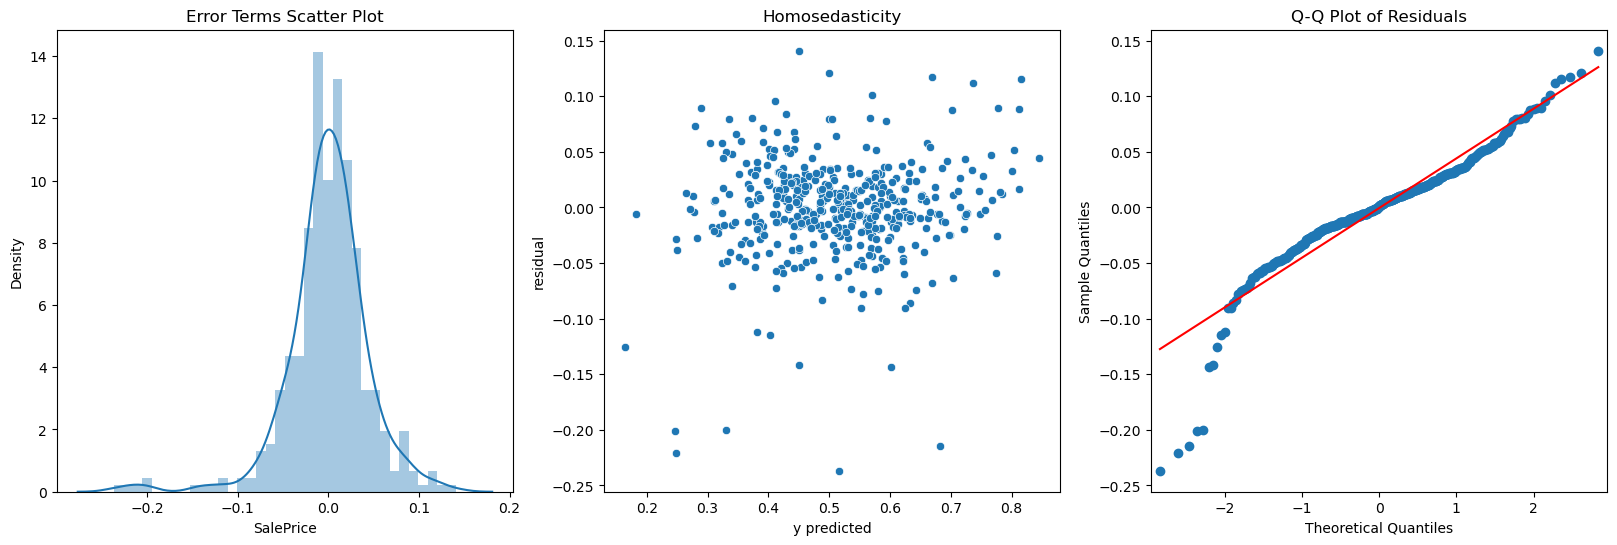

In [346]:
residual=y_test-y_pred_test_lasso

# Plotting y_test and y_pred to understand the spread.
fig, axis = plt.subplots(1, 3, figsize=(20, 6))

sns.distplot(residual,ax=axis[0])
axis[0].set_title("Error Terms Scatter Plot")

# Verifing Homescedasticity, that spread of residue or error terms should be constant accross all y train predicted
sns.scatterplot(x=y_pred_test_lasso,y=residual , ax=axis[1])
axis[1].set_xlabel('y predicted') 
axis[1].set_ylabel('residual') 
axis[1].set_title("Homosedasticity")
import scipy.stats as stats

# Create a Q-Q plot
sm.qqplot(residual, line='s', ax=axis[2])
axis[2].set_title("Q-Q Plot of Residuals")

plt.show()

### Observation
- Residual are linearly distributed
- error terms show no pattern and constant variance
- QQ plot also shows linear distribution of error terms

# Ridge

In [347]:
params = {'alpha': [0.0001,0.0002, 0.001, 0.01, 0.05, 0.1,10.0,20.0,100]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 
ridgeModelBestParam=model_cv.best_params_
print(ridgeModelBestParam)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'alpha': 10.0}


In [348]:
gridSearchStats=pd.DataFrame(model_cv.cv_results_)
gridSearchStats

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.008186,0.000990,0.004188,0.001163,0.0001,{'alpha': 0.0001},-0.032904,-0.032493,-0.034311,-0.031784,...,-0.033197,0.001049,7,-0.024903,-0.021195,-0.022812,-0.025169,-0.024851,-0.023786,0.001546
1,0.007786,0.001176,0.003783,0.000396,0.0002,{'alpha': 0.0002},-0.032904,-0.032491,-0.034308,-0.031782,...,-0.033195,0.001048,6,-0.024903,-0.021195,-0.022811,-0.025169,-0.024851,-0.023786,0.001546
2,0.009176,0.002222,0.004988,0.001092,0.001,{'alpha': 0.001},-0.032904,-0.032476,-0.034283,-0.031765,...,-0.033181,0.001047,5,-0.024905,-0.021197,-0.022809,-0.025168,-0.024851,-0.023786,0.001546
3,0.009774,0.002309,0.005186,0.001465,0.01,{'alpha': 0.01},-0.032891,-0.032367,-0.034098,-0.031580,...,-0.033063,0.001051,4,-0.024919,-0.021218,-0.022809,-0.025163,-0.024854,-0.023792,0.001541
4,0.017152,0.001596,0.008776,0.001828,0.05,{'alpha': 0.05},-0.032765,-0.032197,-0.033785,-0.030956,...,-0.032764,0.001137,3,-0.024924,-0.021279,-0.022829,-0.025163,-0.024871,-0.023813,0.001521
5,0.015566,0.002411,0.006976,0.001787,0.1,{'alpha': 0.1},-0.032611,-0.032114,-0.033642,-0.030370,...,-0.032532,0.001266,2,-0.024920,-0.021334,-0.022858,-0.025178,-0.024886,-0.023835,0.001503
6,0.013773,0.002023,0.006379,0.001024,10.0,{'alpha': 10.0},-0.028859,-0.034908,-0.034965,-0.027906,...,-0.032322,0.003231,1,-0.028605,-0.026719,-0.026713,-0.028794,-0.028150,-0.027796,0.000906
7,0.009769,0.002312,0.004784,0.001163,20.0,{'alpha': 20.0},-0.029782,-0.037241,-0.036397,-0.029911,...,-0.034077,0.003466,8,-0.031136,-0.029441,-0.029516,-0.031303,-0.030420,-0.030363,0.000781
8,0.009575,0.000798,0.004787,0.001596,100,{'alpha': 100},-0.037023,-0.045039,-0.042679,-0.038466,...,-0.041762,0.003454,9,-0.040421,-0.038724,-0.039170,-0.040297,-0.039222,-0.039567,0.000671


### Plotting scatter plot between y test actual and y test pred with different alpha

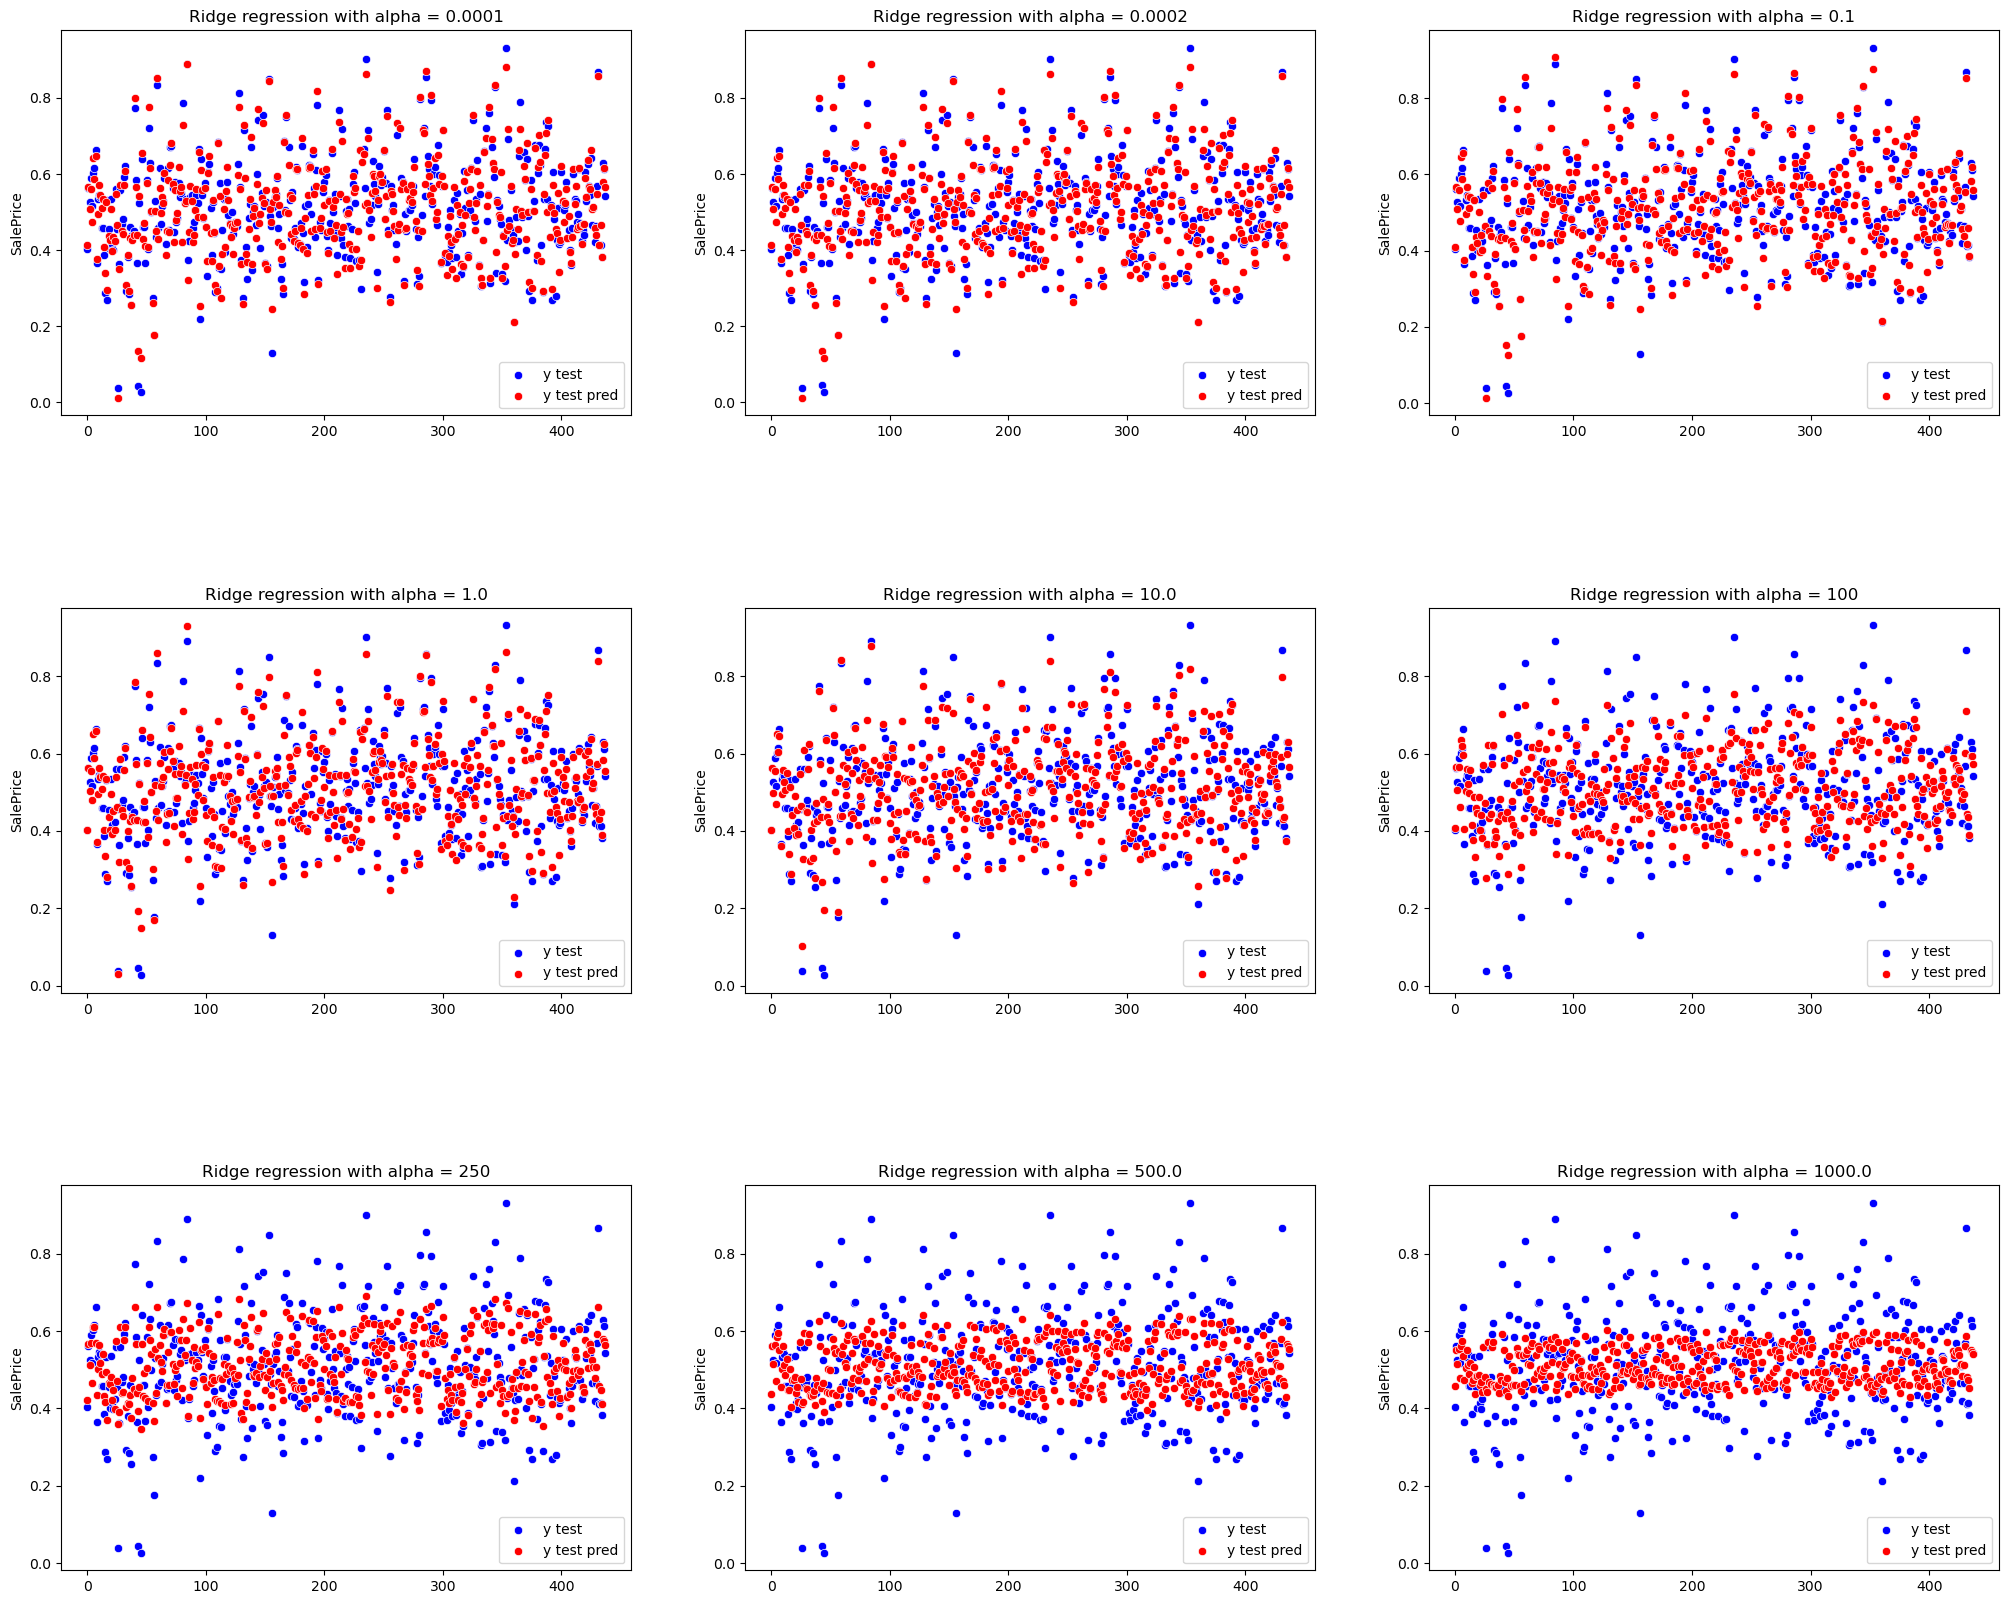

In [349]:
alphaParams=[0.0001, 0.0002, 0.1,1.0, 10.0,100,250, 500.0,1000.0]
fig, axis = plt.subplots(3, 3, figsize=(25, 20))
row=0
col=0
for value in alphaParams:
    if col >=3:
        row=row+1
        col=0
        if row == 3:
            break
        
    ridge = Ridge(alpha=value)
    ridge.fit(x_test, y_test)
    sns.scatterplot(x=range(len(y_test)),y=y_test, ax=axis[row,col],color="blue")
    sns.scatterplot(x=range(len(y_test)),y=ridge.predict(x_test), ax=axis[row,col],color="red")
    axis[row,col].set_title(f"Ridge regression with alpha = {value}")
    axis[row,col].legend(['y test','y test pred'])

    col=col+1  
    
plt.subplots_adjust(hspace=0.5)
plt.show()    

### Observation 

- It can be observed that there is not much differernce between the plot of atual target variable and predicted target variable
from alpha .0001 to 10.

    ##### <b> Reason for significant variation in alpha</b>
    
    - The reason for observing a significant variation in alpha to observe a significant reduction in model performance, could be due to the dataset containing many features, some of which may not be highly relevant. By increasing alpha, Ridge regression reduces the magnitude of coefficients associated with less important features, which can help in reducing model variance without substantially increasing bias. However, it's important to note that while the coefficients for less relevant features are reduced, they are not set to zero.
    - with increase of alpha r2 score and other parameter also changes, out of these parameters alpha 10 is the best
    
#### *******This observation is different because Lasso makes beta coefficient zero for feature selection


In [350]:
ridge = Ridge(alpha=ridgeModelBestParam['alpha'])

ridge.fit(x_train, y_train)
print('Ridge Best alpha value',ridge.get_params)
print('Beta Bo ',ridge.intercept_,'\n')
print('Beta Coefficients')

betaAndCoff=pd.DataFrame(zip(x_train.columns,ridge.coef_))
betaAndCoff=betaAndCoff.rename(columns={0:'independentVariable',1:'beta'})
betaAndCoff.sort_values('beta',ascending=False)

Ridge Best alpha value <bound method BaseEstimator.get_params of Ridge(alpha=10.0)>
Beta Bo  0.24172046904342365 

Beta Coefficients


,independentVariable,beta
3,OverallQual,0.087912
14,GrLivArea,0.060083
19,TotRmsAbvGrd,0.055074
4,OverallCond,0.053297
12,1stFlrSF,0.049739
...,...,...
166,KitchenQual_TA,-0.023660
0,MSSubClass,-0.023724
52,Neighborhood_MeadowV,-0.024784
49,Neighborhood_Edwards,-0.029166


In [351]:
y_pred_train_ridge=ridge.predict(x_train)
y_pred_test_ridge=ridge.predict(x_test)


r2_train_ridge = r2_score(y_train,y_pred_train_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

rssTrain_ridge=np.sum(np.square(y_train-y_pred_train_ridge))
rssTest_ridge=np.sum(np.square(y_test-y_pred_test_ridge))

mseTrain_ridge = mean_squared_error(y_train, y_pred_train_ridge)
rmseTrain_ridge=mseTrain_ridge**.5


mseTest_ridge = mean_squared_error(y_test, y_pred_test_ridge)
rmseTest_ridge=mseTest_ridge**.5

ridgeRegressionDict = {
    'Ridge':{'R2_score Train': r2_train_ridge, 'R2_score Test': r2_test_ridge, 'RSS Train': rssTrain_ridge,
     'RSS Test': rssTest_ridge, 'MSE Train': mseTrain_ridge, 'MSE Test': mseTest_ridge,'RMSE Train': rmseTrain_ridge,
                        'RMSE Test': rmseTest_ridge}
}


ridgeRegressionDictTemp = pd.DataFrame.from_dict(ridgeRegressionDict)
ridgeRegressionDictTemp
modelAnalysisDf=pd.concat([modelAnalysisDf,ridgeRegressionDictTemp],axis=1)
modelAnalysisDf

,Linear Regression,Lasso,Ridge
MSE Test,1.127104e+18,0.001999,0.002251
MSE Train,1.480541e-03,0.001383,0.001586
R2_score Test,-6.473859e+19,0.885180,0.870710
R2_score Train,9.109850e-01,0.916848,0.904645
RMSE Test,1.061652e+09,0.044710,0.047444
RMSE Train,3.847780e-02,0.037189,0.039825
RSS Test,4.936716e+20,0.875573,0.985915
RSS Train,1.511633e+00,1.412076,1.619305


## Inference
- The Lasso regression model is the best among the three due to its lowest Mean Squared Error (MSE) and Root Mean Squared Error (RMSE), and highest R-squared (R2_score) on both training and test datasets, indicating it provides the most accurate predictions and best explains the variance in the data. The Linear Regression model significantly underperforms, particularly shown by its negative R2_score on the test set, while the Ridge model performs well but is slightly outperformed by Lasso.

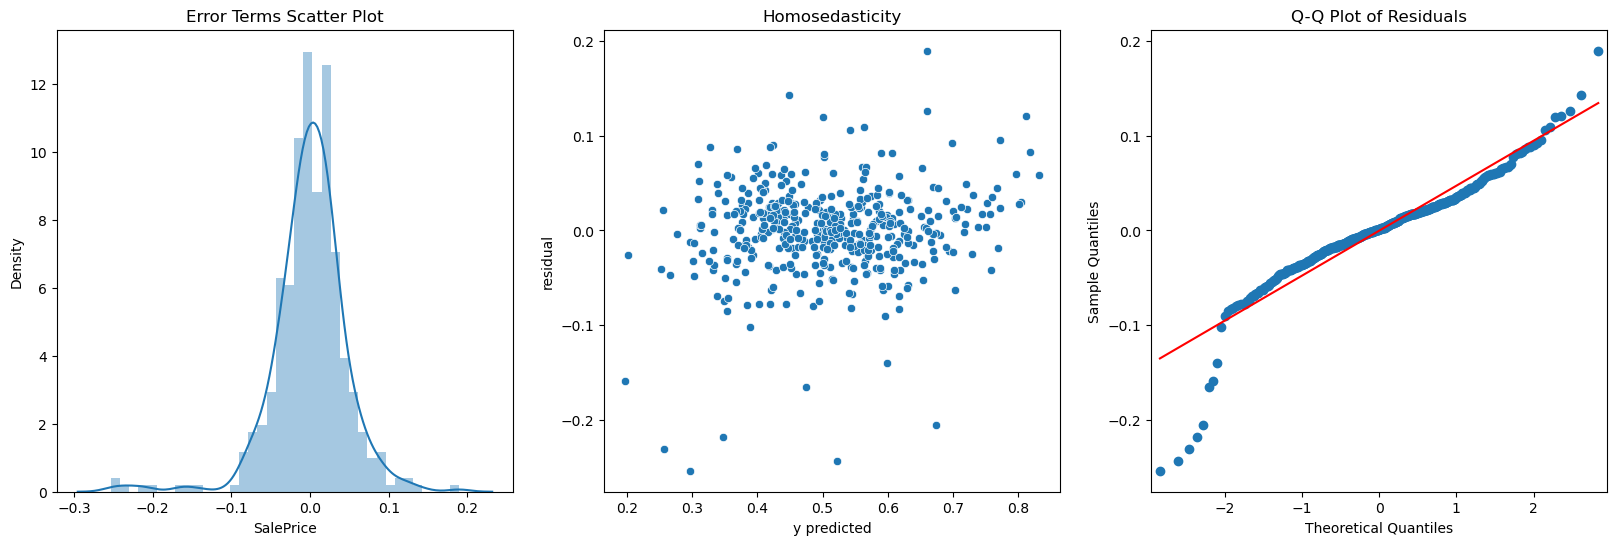

In [352]:
residual=y_test-y_pred_test_ridge

# Plotting y_test and y_pred to understand the spread.
fig, axis = plt.subplots(1, 3, figsize=(20, 6))

sns.distplot(residual,ax=axis[0])
axis[0].set_title("Error Terms Scatter Plot")

# Verifing Homescedasticity, that spread of residue or error terms should be constant accross all y train predicted
sns.scatterplot(x=y_pred_test_ridge,y=residual , ax=axis[1])


axis[1].set_xlabel('y predicted') 
axis[1].set_ylabel('residual') 
axis[1].set_title("Homosedasticity")
import scipy.stats as stats

# Create a Q-Q plot
sm.qqplot(residual, line='s', ax=axis[2])
axis[2].set_title("Q-Q Plot of Residuals")

plt.show()

### Observation
- Residual are linearly distributed
- error terms show no pattern and constant variance
- QQ plot also shows linear distribution of error terms